# Team Project - Team 3

Objective: Create a model to predict if a car insurance claim will be filed based on data primarily relating to information about vehicles

## Import packages and libraries

In [27]:
import pandas as pd
import numpy as np 
import seaborn as sns
import sagemaker
import boto3


from matplotlib import pyplot as plt
from numpy import where
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from collections import Counter
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer
from sagemaker.xgboost.estimator import XGBoost
from time import gmtime, strftime
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)


%matplotlib inline
pd.set_option('display.max_columns', None)

## Load raw data from S3

In [28]:
df = pd.read_csv('s3://techexcellence.ml.project.team3/CarInsuranceClaim/data/train.csv')

df.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,2,Yes,Yes,No,Yes,Yes,Drum,1197,4,Automatic,5,Electric,4.8,3995,1735,1515,1335,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


## Exploratory data analysis and data preparation

### Initial data preparation

In [29]:
# Remove policy ID
df = df.drop(['policy_id'], axis=1)

In [30]:
#combine height, weight, length into a single variable called volume 
df['volume'] = df['height']*df['width']*df['length']
df[['volume', 'height', 'width', 'length']].head()
df.drop(columns=['height', 'width', 'length'], axis=1, inplace=True)

### Exploratory Analysis - Dataset features

In [31]:
df.shape

(58592, 41)

In [32]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
policy_tenure,58592.0,6.112462e-01,4.141565e-01,2.735273e-03,2.102496e-01,5.737917e-01,1.039104e+00,1.396641e+00
age_of_car,58592.0,6.942364e-02,5.672065e-02,0.000000e+00,2.000000e-02,6.000000e-02,1.100000e-01,1.000000e+00
age_of_policyholder,58592.0,4.694201e-01,1.228859e-01,2.884615e-01,3.653846e-01,4.519231e-01,5.480769e-01,1.000000e+00
population_density,58592.0,1.882686e+04,1.766017e+04,2.900000e+02,6.112000e+03,8.794000e+03,2.700300e+04,7.343000e+04
make,58592.0,1.763722e+00,1.136988e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,5.000000e+00
airbags,58592.0,3.137066e+00,1.832641e+00,1.000000e+00,2.000000e+00,2.000000e+00,6.000000e+00,6.000000e+00
displacement,58592.0,1.162356e+03,2.663048e+02,7.960000e+02,7.960000e+02,1.197000e+03,1.493000e+03,1.498000e+03
cylinder,58592.0,3.626963e+00,4.836160e-01,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
gear_box,58592.0,5.245443e+00,4.303533e-01,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,6.000000e+00
turning_radius,58592.0,4.852893e+00,2.280608e-01,4.500000e+00,4.600000e+00,4.800000e+00,5.000000e+00,5.200000e+00


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_tenure                     58592 non-null  float64
 1   age_of_car                        58592 non-null  float64
 2   age_of_policyholder               58592 non-null  float64
 3   area_cluster                      58592 non-null  object 
 4   population_density                58592 non-null  int64  
 5   make                              58592 non-null  int64  
 6   segment                           58592 non-null  object 
 7   model                             58592 non-null  object 
 8   fuel_type                         58592 non-null  object 
 9   max_torque                        58592 non-null  object 
 10  max_power                         58592 non-null  object 
 11  engine_type                       58592 non-null  object 
 12  airb

In [34]:
df.duplicated().any()

False

In [35]:
df.nunique()

policy_tenure                       58592
age_of_car                             49
age_of_policyholder                    75
area_cluster                           22
population_density                     22
make                                    5
segment                                 6
model                                  11
fuel_type                               3
max_torque                              9
max_power                               9
engine_type                            11
airbags                                 3
is_esc                                  2
is_adjustable_steering                  2
is_tpms                                 2
is_parking_sensors                      2
is_parking_camera                       2
rear_brakes_type                        2
displacement                            9
cylinder                                2
transmission_type                       2
gear_box                                2
steering_type                     

SUMMARY: No duplicates, no null values, and a mix of categorical and numerical data with approximately 58,500 observations

### Exploratory Analysis - Target variable

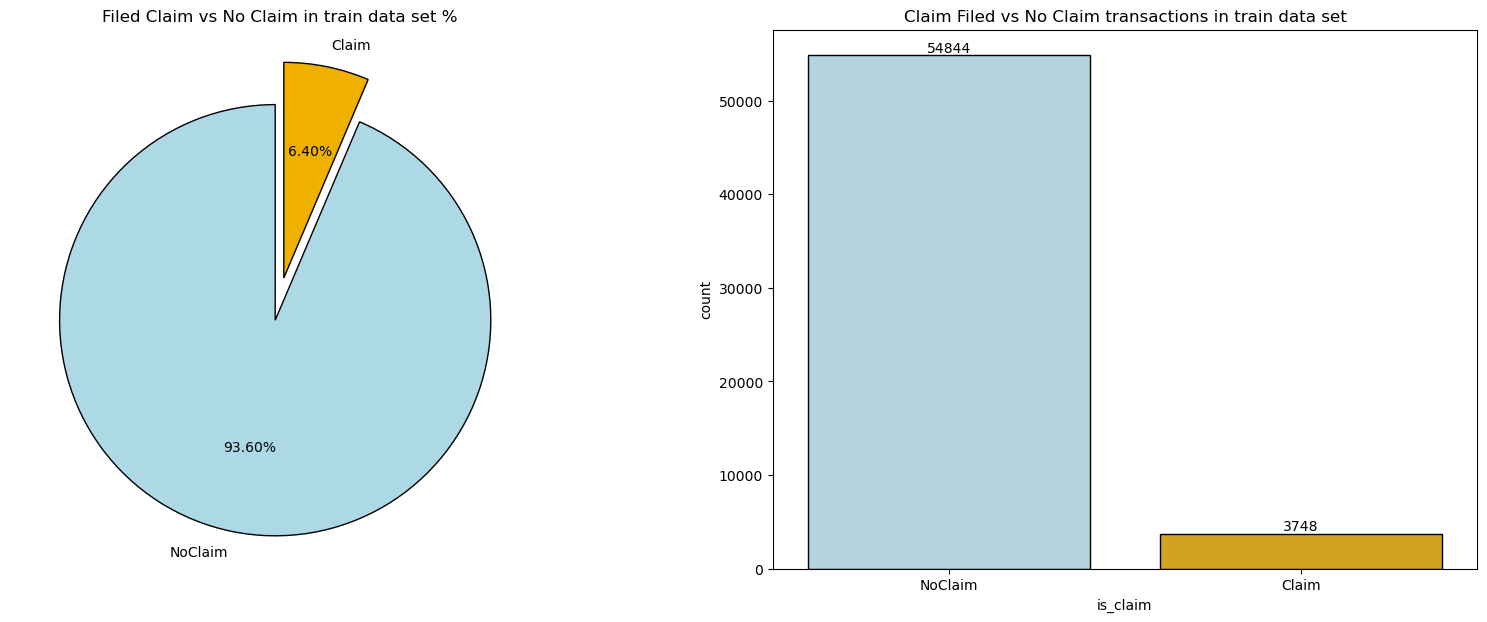

In [36]:
palette = ["#ADD8E6","#EFB000"] 

l1 = list(df["is_claim"].value_counts())
pie_values = [l1[0] / sum(l1) * 100, l1[1] / sum(l1) * 100]

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,7))

plt.subplot(1,2,1)
plt.pie(pie_values,labels = ['NoClaim','Claim'], 
        autopct = '%1.2f%%',
        startangle = 90,
        explode = (0.1,0.1),
        colors = palette,
        wedgeprops = {'edgecolor': 'black','linewidth': 1, 'antialiased' : True})
plt.title('Filed Claim vs No Claim in train data set %');

plt.subplot(1,2,2)
ax = sns.countplot(data = df, 
                   x='is_claim', 
                   palette = palette, 
                   edgecolor = 'black')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xticklabels(['NoClaim','Claim'])
    
plt.title('Claim Filed vs No Claim transactions in train data set')
plt.show()

SUMMARY: The dataset is imbalanced with the majority class pointing to claims not being filed

### Additional data preparation

In [37]:
#split max_torque and max_power columns 
#max_torque
df[['max_torque_NM','max_torque_RPM']] = df['max_torque'].str.split("@",expand=True)
df['max_torque_NM'] = df['max_torque_NM'].str.replace('Nm', '').astype(float)
df['max_torque_RPM'] = df['max_torque_RPM'].str.replace('rpm', '').astype(float)
df.drop(columns=['max_torque'], inplace=True)
#max_power
df[['max_power_NM','max_power_RPM']] = df['max_power'].str.split("@",expand=True)
df['max_power_NM'] = df['max_power_NM'].str.replace('bhp', '').astype(float)
df['max_power_RPM'] = df['max_power_RPM'].str.replace('rpm', '').astype(float)
df.drop(columns=['max_power'], inplace=True)
#view
df[['max_torque_NM','max_torque_RPM', 'max_power_NM', 'max_power_RPM']].head()

,max_torque_NM,max_torque_RPM,max_power_NM,max_power_RPM
0,60.0,3500.0,40.36,6000.0
1,60.0,3500.0,40.36,6000.0
2,60.0,3500.0,40.36,6000.0
3,113.0,4400.0,88.50,6000.0
4,91.0,4250.0,67.06,5500.0


### Correlation evaluation

In [38]:
print("Correlation Matrix")
print()
chi_df = df.apply(lambda x : x.astype('category').cat.codes)
def get_redundant_pairs(chi_df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = chi_df.columns
    for i in range(0, chi_df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(chi_df, n=5):
    au_corr = chi_df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(chi_df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(chi_df, 30))

Correlation Matrix

Top Absolute Correlations
is_power_door_locks     is_central_locking                  1.000000
                        is_ecw                              1.000000
is_rear_window_wiper    is_rear_window_washer               1.000000
is_central_locking      is_ecw                              1.000000
is_tpms                 rear_brakes_type                    1.000000
max_torque_NM           max_power_NM                        0.994111
is_front_fog_lights     is_driver_seat_height_adjustable    0.987346
rear_brakes_type        gear_box                            0.983270
is_tpms                 gear_box                            0.983270
displacement            max_torque_NM                       0.968034
                        max_power_NM                        0.957526
is_adjustable_steering  cylinder                            0.957287
airbags                 is_rear_window_wiper                0.956949
                        is_rear_window_washer            

Notes:
- Power door locks and central locking are very similar and correlated. Removing "is_central_locking"
- Rear window wiper and rear window wiper work together, removing "is_rear_window_washer"

Potentially interesting:
- "is_adjustable_steering" and "is_driver_seat_height_adjustable" combined to just "Adjustable"?
- Logically, we would assume if a car has a larger "turning_radius" it would imply that the car has a longer "length"
- Segment seems to depend in part with the length of the car

In [39]:
df.drop(columns=['is_central_locking', 'is_rear_window_washer'], inplace=True)

### Transforming variables

In [40]:
#convert categorical variables into dummy variables 

df['make'] = df['make'].astype(str)
object_columns = df.select_dtypes(include = 'object').columns
df_dummies = pd.get_dummies(df[object_columns], drop_first=True)
df = df.join(df_dummies)
df.drop(columns=object_columns, inplace=True)
df.head()

,policy_tenure,age_of_car,age_of_policyholder,population_density,airbags,displacement,cylinder,gear_box,turning_radius,gross_weight,ncap_rating,is_claim,volume,max_torque_NM,max_torque_RPM,max_power_NM,max_power_RPM,area_cluster_C10,area_cluster_C11,area_cluster_C12,area_cluster_C13,area_cluster_C14,area_cluster_C15,area_cluster_C16,area_cluster_C17,area_cluster_C18,area_cluster_C19,area_cluster_C2,area_cluster_C20,area_cluster_C21,area_cluster_C22,area_cluster_C3,area_cluster_C4,area_cluster_C5,area_cluster_C6,area_cluster_C7,area_cluster_C8,area_cluster_C9,make_2,make_3,make_4,make_5,segment_B1,segment_B2,segment_C1,segment_C2,segment_Utility,model_M10,model_M11,model_M2,model_M3,model_M4,model_M5,model_M6,model_M7,model_M8,model_M9,fuel_type_Diesel,fuel_type_Petrol,engine_type_1.2 L K Series Engine,engine_type_1.2 L K12N Dualjet,engine_type_1.5 L U2 CRDi,engine_type_1.5 Turbocharged Revotorq,engine_type_1.5 Turbocharged Revotron,engine_type_F8D Petrol Engine,engine_type_G12B,engine_type_K Series Dual jet,engine_type_K10C,engine_type_i-DTEC,is_esc_Yes,is_adjustable_steering_Yes,is_tpms_Yes,is_parking_sensors_Yes,is_parking_camera_Yes,rear_brakes_type_Drum,transmission_type_Manual,steering_type_Manual,steering_type_Power,is_front_fog_lights_Yes,is_rear_window_wiper_Yes,is_rear_window_defogger_Yes,is_brake_assist_Yes,is_power_door_locks_Yes,is_power_steering_Yes,is_driver_seat_height_adjustable_Yes,is_day_night_rear_view_mirror_Yes,is_ecw_Yes,is_speed_alert_Yes
0,0.515874,0.05,0.644231,4990,2,796,3,5,4.6,1185,0,0,7698283125,60.0,3500.0,40.36,6000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1
1,0.672619,0.02,0.375000,27003,2,796,3,5,4.6,1185,0,0,7698283125,60.0,3500.0,40.36,6000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1
2,0.841110,0.02,0.384615,4076,2,796,3,5,4.6,1185,0,0,7698283125,60.0,3500.0,40.36,6000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1
3,0.900277,0.11,0.432692,21622,2,1197,4,5,4.8,1335,2,0,10500957375,113.0,4400.0,88.50,6000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,1,0,1,1,1,1,1,1,1,1
4,0.596403,0.11,0.634615,34738,2,999,3,5,5.0,1155,2,0,8777961010,91.0,4250.0,67.06,5500.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,1,1,1


In [41]:
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df), columns = df.columns)

### Train/Test split and balancing training set

In [42]:
#Train Test Split  
train_size=0.8

X = df_scaled.drop(columns = ['is_claim']).copy()
y = df['is_claim']

# In the first step we will split the data in training and remaining dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=42)

print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(46873, 87)
(46873,)
(11719, 87)
(11719,)


(None, None)

In [43]:
#Balance Data set 
# Oversample and plot imbalanced dataset with SMOTE

# summarize class distribution
counter = Counter(y_train)
print(counter)
# transform the dataset
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
# summarize the new class distribution
counter = Counter(y_train)
print(counter)

Counter({0: 43881, 1: 2992})
Counter({0: 43881, 1: 43881})


## Dummy Model

In [44]:
features = list(df.columns[:-1])

In [45]:
X_dummy = df[features]
y_dummy = df['is_claim']

In [46]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)

In [47]:
dummy_clf.fit(X_dummy, y_dummy)

DummyClassifier(random_state=42, strategy='most_frequent')

In [48]:
y_pred = dummy_clf.predict(X_dummy)

In [49]:
#Accuracy
dummy_clf.score(X_dummy, y_dummy)

0.9360322228290552

In [50]:
#F1 score
f1_score(y_dummy, y_pred)

0.0

SUMMARY: The high level of accuracy does not actually come with the best predictive power as shown by the F1 sore. Moving forward, F1 score will be the primary evaluation metric.

## Save processed data to s3 

In [53]:
# X_train, X_test, y_train, y_test
X_train.to_csv('s3://techexcellence.ml.project.team3/CarInsuranceClaim/processed_data/X_train.csv', index=False)
X_test.to_csv('s3://techexcellence.ml.project.team3/CarInsuranceClaim/processed_data/X_test.csv', index=False)
y_train.to_csv('s3://techexcellence.ml.project.team3/CarInsuranceClaim/processed_data/y_train.csv', index=False)
y_test.to_csv('s3://techexcellence.ml.project.team3/CarInsuranceClaim/processed_data/y_test.csv', index=False)
df.to_csv('s3://techexcellence.ml.project.team3/CarInsuranceClaim/processed_data/processed_df.csv', index=False)
